# Unsupervised Learning Trading strategy
*Download Stock Data like(sp500)
*Calculate Different features and indicator of the stock
-Aggregate on the monthly Basis and filter upto
150 most liquid stock
-Calculate MOnthly returns For different time-horizons
-Download Fama-french factors and Calculate rolling Factor betas
-For each month fit a k-means clustering to group similar assest bases on their features
-for each month select assests based on the cluster and form a portfolio based on efficent frontier max sharpe ratio optimization
-Visulize portfolio and compare SP500

# Importing Libraries

In [8]:
!pip install pandas_datareader
!pip install pandas_ta

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [10]:
sp500=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [11]:
sp500

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [12]:
sp500['Symbol']=sp500['Symbol'].str.replace('.','-')
symbol_list=sp500.Symbol.unique().tolist()
symbol_list.remove('VLTO')

# 1)Download the data for all the symbols

In [13]:
from pandas.core.tools.datetimes import to_datetime
enddate='2023-11-01'
startdate=pd.to_datetime(enddate)-pd.DateOffset(365*8)

In [14]:
df=yf.download(tickers=symbol_list,start=startdate,end=enddate)

[*********************100%%**********************]  502 of 502 completed


1 Failed download:
['APA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2015-11-03 00:00:00 -> 2023-11-01)')


In [15]:
df

Adj Close                                                 \
                     A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2015-11-03   35.829102  44.437515   27.814413   44.189808         NaN   
2015-11-04   35.894642  43.606110   27.685059   45.159538         NaN   
2015-11-05   35.857193  43.577438   27.557440   44.430470         NaN   
2015-11-06   35.707401  43.328976   27.589342   45.393135         NaN   
2015-11-09   35.501431  42.669575   27.477674   44.756073         NaN   
...                ...        ...         ...         ...         ...   
2023-10-25  103.400002  11.040000  171.100006  145.259995  118.500000   
2023-10-26  104.309998  11.150000  166.889999  145.199997  115.470001   
2023-10-27  102.769997  10.920000  168.220001  138.929993  114.089996   
2023-10-30  101.169998  11.180000  170.289993  141.889999  116.949997   
2023-10-31  103.370003  11.150000  170.770004  141.179993  118.290001   

                                                                      ...  \
                  ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                  ...   
2015-11-03  39.177307  24.870001   94.425095   90.360001   51.364300  ...   
2015-11-04  38.893219  24.803333   93.729965   91.010002   51.220352  ...   
2015-11-05  38.893219  24.843332   93.351608   90.550003   51.110264  ...   
2015-11-06  39.280602  24.843332   93.272408   90.690002   52.244919  ...   
2015-11-09  38.781307  24.700001   92.286873   89.800003   51.618332  ...   
...               ...        ...         ...         ...         ...  ...   
2023-10-25  93.570000  83.489998  292.679993  521.140015  159.789993  ...   
2023-10-26  93.980003  82.449997  292.040009  514.280029  160.860001  ...   
2023-10-27  92.849998  81.360001  290.040009  508.119995  160.570007  ...   
2023-10-30  93.000000  82.879997  292.700012  526.940002  155.880005  ...   
2023-10-31  94.550003  86.680000  297.089996  532.059998  157.330002  ...   

             Volume                                                         \
               WYNN      XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2015-11-03  4616600  1817800  20115900  1140500  1658900  3707015  1136502   
2015-11-04  4286300  1925300  14245400  1009500  1008600  3273579  1168123   
2015-11-05  2261500  2228800  12291100  1021100   889400  3596987  1092109   
2015-11-06  2123700  5854600  12491700   964400   843400  3502538  1451682   
2015-11-09  7502600  3674400  13551200  1026200   905600  6944568   758904   
...             ...      ...       ...      ...      ...      ...      ...   
2023-10-25  1518500  3133100  22047300  5733000  1411800   985800  1698500   
2023-10-26  2183400  3468000  18768300  5965700  1155500  1374500  1197700   
2023-10-27  1587500  4310600  23092000  2707000  1241700  2331000  1534500   
2023-10-30  1343100  3818400  19379900  3388500  1761600  1551900  1309800   
2023-10-31  1471700  3832300  22185200  3668700  3449200  2006600  1382000   

                                      
              ZBRA     ZION      ZTS  
Date                                  
2015-11-03  253300  2413900  8007200  
2015-11-04  521800  1863400  7718100  
2015-11-05  381700  3032100  5177500  
2015-11-06  584300  3536200  3496200  
2015-11-09  845000  2032700  3707900  
...            ...      ...      ...  
2023-10-25  577900  2713300  1273600  
2023-10-26  735500  4151700  2891100  
2023-10-27  565000  2498300  2407100  
2023-10-30  970000  2837100  2756200  
2023-10-31  914200  2387400  3208900  

[2012 rows x 3012 columns]

In [16]:
df=df.stack()

In [17]:
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2015-11-03 A      35.829102   38.270000   38.520000   38.160000   38.310001   
           AAL    44.437515   46.500000   47.090000   46.080002   47.020000   
           AAPL   27.814413   30.642500   30.872499   30.174999   30.197500   
           ABBV   44.189808   62.430000   63.720001   61.919998   63.119999   
           ABT    39.177307   45.509998   45.639999   45.040001   45.360001   
...                     ...         ...         ...         ...         ...   
2023-10-31 YUM   120.860001  120.860001  121.360001  119.419998  120.610001   
           ZBH   104.410004  104.410004  105.169998  103.489998  104.000000   
           ZBRA  209.429993  209.429993  215.000000  203.089996  213.899994   
           ZION   30.850000   30.850000   30.980000   29.780001   30.080000   
           ZTS   157.000000  157.000000  158.529999  156.089996  157.509995   

                      Volume  
Date                          
2015-11-03 A       1485800.0  
           AAL     6983200.0  
           AAPL  182076000.0  
           ABBV    8754700.0  
           ABT     3933800.0  
...                      ...  
2023-10-31 YUM     2006600.0  
           ZBH     1382000.0  
           ZBRA     914200.0  
           ZION    2387400.0  
           ZTS     3208900.0  

[992540 rows x 6 columns]

In [18]:
df.index.names =['Date','Indices']

In [19]:
df

Adj Close       Close        High         Low  \
Date       Indices                                                   
2015-11-03 A         35.829102   38.270000   38.520000   38.160000   
           AAL       44.437515   46.500000   47.090000   46.080002   
           AAPL      27.814413   30.642500   30.872499   30.174999   
           ABBV      44.189808   62.430000   63.720001   61.919998   
           ABT       39.177307   45.509998   45.639999   45.040001   
...                        ...         ...         ...         ...   
2023-10-31 YUM      120.860001  120.860001  121.360001  119.419998   
           ZBH      104.410004  104.410004  105.169998  103.489998   
           ZBRA     209.429993  209.429993  215.000000  203.089996   
           ZION      30.850000   30.850000   30.980000   29.780001   
           ZTS      157.000000  157.000000  158.529999  156.089996   

                          Open       Volume  
Date       Indices                           
2015-11-03 A         38.310001    1485800.0  
           AAL       47.020000    6983200.0  
           AAPL      30.197500  182076000.0  
           ABBV      63.119999    8754700.0  
           ABT       45.360001    3933800.0  
...                        ...          ...  
2023-10-31 YUM      120.610001    2006600.0  
           ZBH      104.000000    1382000.0  
           ZBRA     213.899994     914200.0  
           ZION      30.080000    2387400.0  
           ZTS      157.509995    3208900.0  

[992540 rows x 6 columns]

 # 2)Calculate features and techinal indicators on the stock
    .Garman-Klass Voltaility
    .RSI
    .Bollinger Bands
    .ATR
    .MACD
    .DOllar volume
           

In [20]:
# Garman-klass Voltaility
df['Garman_klass_Voltaility']=(((np. log(df.High)-np.log(df.Low))**2)/2)-((2*np.log(2)-1)*((np.log(df['Adj Close'])-np.log(df['Open']))**2))

In [21]:
# RSI (Relative Strength Index)
df['rsi']=df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.rsi(close=x ,length=20))

<Axes: xlabel='Date'>

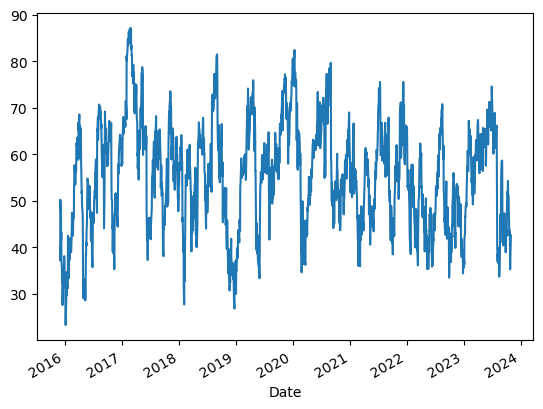

In [22]:
df.xs('AAPL',level=1)['rsi'].plot()

In [23]:
#Bollinger Bands
df['bb_low']=df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands( close=np.log1p(x),length=20).iloc[:,0])
df['bb_mid']=df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands( close=np.log1p(x),length=20).iloc[:,1])
df['bb_high']=df.groupby(level=1)['Adj Close'].transform(lambda x: pandas_ta.bbands( close=np.log1p(x),length=20).iloc[:,2])

In [24]:
df

Adj Close       Close        High         Low  \
Date       Indices                                                   
2015-11-03 A         35.829102   38.270000   38.520000   38.160000   
           AAL       44.437515   46.500000   47.090000   46.080002   
           AAPL      27.814413   30.642500   30.872499   30.174999   
           ABBV      44.189808   62.430000   63.720001   61.919998   
           ABT       39.177307   45.509998   45.639999   45.040001   
...                        ...         ...         ...         ...   
2023-10-31 YUM      120.860001  120.860001  121.360001  119.419998   
           ZBH      104.410004  104.410004  105.169998  103.489998   
           ZBRA     209.429993  209.429993  215.000000  203.089996   
           ZION      30.850000   30.850000   30.980000   29.780001   
           ZTS      157.000000  157.000000  158.529999  156.089996   

                          Open       Volume  Garman_klass_Voltaility  \
Date       Indices                                                     
2015-11-03 A         38.310001    1485800.0                -0.001687   
           AAL       47.020000    6983200.0                -0.000998   
           AAPL      30.197500  182076000.0                -0.002349   
           ABBV      63.119999    8754700.0                -0.048696   
           ABT       45.360001    3933800.0                -0.008207   
...                        ...          ...                      ...   
2023-10-31 YUM      120.610001    2006600.0                 0.000128   
           ZBH      104.000000    1382000.0                 0.000124   
           ZBRA     213.899994     914200.0                 0.001452   
           ZION      30.080000    2387400.0                 0.000534   
           ZTS      157.509995    3208900.0                 0.000116   

                          rsi    bb_low    bb_mid   bb_high  
Date       Indices                                           
2015-11-03 A              NaN       NaN       NaN       NaN  
           AAL            NaN       NaN       NaN       NaN  
           AAPL           NaN       NaN       NaN       NaN  
           ABBV           NaN       NaN       NaN       NaN  
           ABT            NaN       NaN       NaN       NaN  
...                       ...       ...       ...       ...  
2023-10-31 YUM      45.740644  4.766663  4.792771  4.818880  
           ZBH      36.177908  4.620143  4.672539  4.724935  
           ZBRA     38.096094  5.286335  5.362025  5.437716  
           ZION     42.799190  3.370763  3.517409  3.664054  
           ZTS      28.743037  5.049566  5.130928  5.212291  

[992540 rows x 11 columns]

In [25]:
 # ATR Calculation  function
def atr_call(data):
    atr=pandas_ta.atr(high=data['High'],
                      close=data['Close'],
                      low=data['Low'],
                      length=20)
    return atr.sub(atr.mean()).div(atr.std())

In [26]:
# loading atr in df 
df['atr']=df.groupby(level=1,group_keys=False).apply(atr_call)

In [27]:
df

Adj Close       Close        High         Low  \
Date       Indices                                                   
2015-11-03 A         35.829102   38.270000   38.520000   38.160000   
           AAL       44.437515   46.500000   47.090000   46.080002   
           AAPL      27.814413   30.642500   30.872499   30.174999   
           ABBV      44.189808   62.430000   63.720001   61.919998   
           ABT       39.177307   45.509998   45.639999   45.040001   
...                        ...         ...         ...         ...   
2023-10-31 YUM      120.860001  120.860001  121.360001  119.419998   
           ZBH      104.410004  104.410004  105.169998  103.489998   
           ZBRA     209.429993  209.429993  215.000000  203.089996   
           ZION      30.850000   30.850000   30.980000   29.780001   
           ZTS      157.000000  157.000000  158.529999  156.089996   

                          Open       Volume  Garman_klass_Voltaility  \
Date       Indices                                                     
2015-11-03 A         38.310001    1485800.0                -0.001687   
           AAL       47.020000    6983200.0                -0.000998   
           AAPL      30.197500  182076000.0                -0.002349   
           ABBV      63.119999    8754700.0                -0.048696   
           ABT       45.360001    3933800.0                -0.008207   
...                        ...          ...                      ...   
2023-10-31 YUM      120.610001    2006600.0                 0.000128   
           ZBH      104.000000    1382000.0                 0.000124   
           ZBRA     213.899994     914200.0                 0.001452   
           ZION      30.080000    2387400.0                 0.000534   
           ZTS      157.509995    3208900.0                 0.000116   

                          rsi    bb_low    bb_mid   bb_high       atr  
Date       Indices                                                     
2015-11-03 A              NaN       NaN       NaN       NaN       NaN  
           AAL            NaN       NaN       NaN       NaN       NaN  
           AAPL           NaN       NaN       NaN       NaN       NaN  
           ABBV           NaN       NaN       NaN       NaN       NaN  
           ABT            NaN       NaN       NaN       NaN       NaN  
...                       ...       ...       ...       ...       ...  
2023-10-31 YUM      45.740644  4.766663  4.792771  4.818880  0.310878  
           ZBH      36.177908  4.620143  4.672539  4.724935 -0.336603  
           ZBRA     38.096094  5.286335  5.362025  5.437716 -0.015549  
           ZION     42.799190  3.370763  3.517409  3.664054  0.128116  
           ZTS      28.743037  5.049566  5.130928  5.212291  0.598300  

[992540 rows x 12 columns]

In [28]:
#Building MACD Indicators
def macd_com(close):
    macdt= pandas_ta.macd(close=close,length=20).iloc[:,0]
    return macdt.sub(macdt.mean()).div(macdt.std())
    

In [29]:
df['MACD']=df.groupby(level=1 ,group_keys=False)['Adj Close'].apply(macd_com)

In [30]:
df

Adj Close       Close        High         Low  \
Date       Indices                                                   
2015-11-03 A         35.829102   38.270000   38.520000   38.160000   
           AAL       44.437515   46.500000   47.090000   46.080002   
           AAPL      27.814413   30.642500   30.872499   30.174999   
           ABBV      44.189808   62.430000   63.720001   61.919998   
           ABT       39.177307   45.509998   45.639999   45.040001   
...                        ...         ...         ...         ...   
2023-10-31 YUM      120.860001  120.860001  121.360001  119.419998   
           ZBH      104.410004  104.410004  105.169998  103.489998   
           ZBRA     209.429993  209.429993  215.000000  203.089996   
           ZION      30.850000   30.850000   30.980000   29.780001   
           ZTS      157.000000  157.000000  158.529999  156.089996   

                          Open       Volume  Garman_klass_Voltaility  \
Date       Indices                                                     
2015-11-03 A         38.310001    1485800.0                -0.001687   
           AAL       47.020000    6983200.0                -0.000998   
           AAPL      30.197500  182076000.0                -0.002349   
           ABBV      63.119999    8754700.0                -0.048696   
           ABT       45.360001    3933800.0                -0.008207   
...                        ...          ...                      ...   
2023-10-31 YUM      120.610001    2006600.0                 0.000128   
           ZBH      104.000000    1382000.0                 0.000124   
           ZBRA     213.899994     914200.0                 0.001452   
           ZION      30.080000    2387400.0                 0.000534   
           ZTS      157.509995    3208900.0                 0.000116   

                          rsi    bb_low    bb_mid   bb_high       atr  \
Date       Indices                                                      
2015-11-03 A              NaN       NaN       NaN       NaN       NaN   
           AAL            NaN       NaN       NaN       NaN       NaN   
           AAPL           NaN       NaN       NaN       NaN       NaN   
           ABBV           NaN       NaN       NaN       NaN       NaN   
           ABT            NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2023-10-31 YUM      45.740644  4.766663  4.792771  4.818880  0.310878   
           ZBH      36.177908  4.620143  4.672539  4.724935 -0.336603   
           ZBRA     38.096094  5.286335  5.362025  5.437716 -0.015549   
           ZION     42.799190  3.370763  3.517409  3.664054  0.128116   
           ZTS      28.743037  5.049566  5.130928  5.212291  0.598300   

                        MACD  
Date       Indices            
2015-11-03 A             NaN  
           AAL           NaN  
           AAPL          NaN  
           ABBV          NaN  
           ABT           NaN  
...                      ...  
2023-10-31 YUM     -1.075179  
           ZBH     -1.258160  
           ZBRA    -1.179021  
           ZION    -1.192369  
           ZTS     -2.660415  

[992540 rows x 13 columns]

In [31]:
# Dollar Volume
df['Dollar_volume']=df['Adj Close']* df['Volume']/1e6

In [32]:
df

Adj Close       Close        High         Low  \
Date       Indices                                                   
2015-11-03 A         35.829102   38.270000   38.520000   38.160000   
           AAL       44.437515   46.500000   47.090000   46.080002   
           AAPL      27.814413   30.642500   30.872499   30.174999   
           ABBV      44.189808   62.430000   63.720001   61.919998   
           ABT       39.177307   45.509998   45.639999   45.040001   
...                        ...         ...         ...         ...   
2023-10-31 YUM      120.860001  120.860001  121.360001  119.419998   
           ZBH      104.410004  104.410004  105.169998  103.489998   
           ZBRA     209.429993  209.429993  215.000000  203.089996   
           ZION      30.850000   30.850000   30.980000   29.780001   
           ZTS      157.000000  157.000000  158.529999  156.089996   

                          Open       Volume  Garman_klass_Voltaility  \
Date       Indices                                                     
2015-11-03 A         38.310001    1485800.0                -0.001687   
           AAL       47.020000    6983200.0                -0.000998   
           AAPL      30.197500  182076000.0                -0.002349   
           ABBV      63.119999    8754700.0                -0.048696   
           ABT       45.360001    3933800.0                -0.008207   
...                        ...          ...                      ...   
2023-10-31 YUM      120.610001    2006600.0                 0.000128   
           ZBH      104.000000    1382000.0                 0.000124   
           ZBRA     213.899994     914200.0                 0.001452   
           ZION      30.080000    2387400.0                 0.000534   
           ZTS      157.509995    3208900.0                 0.000116   

                          rsi    bb_low    bb_mid   bb_high       atr  \
Date       Indices                                                      
2015-11-03 A              NaN       NaN       NaN       NaN       NaN   
           AAL            NaN       NaN       NaN       NaN       NaN   
           AAPL           NaN       NaN       NaN       NaN       NaN   
           ABBV           NaN       NaN       NaN       NaN       NaN   
           ABT            NaN       NaN       NaN       NaN       NaN   
...                       ...       ...       ...       ...       ...   
2023-10-31 YUM      45.740644  4.766663  4.792771  4.818880  0.310878   
           ZBH      36.177908  4.620143  4.672539  4.724935 -0.336603   
           ZBRA     38.096094  5.286335  5.362025  5.437716 -0.015549   
           ZION     42.799190  3.370763  3.517409  3.664054  0.128116   
           ZTS      28.743037  5.049566  5.130928  5.212291  0.598300   

                        MACD  Dollar_volume  
Date       Indices                           
2015-11-03 A             NaN      53.234879  
           AAL           NaN     310.316057  
           AAPL          NaN    5064.337074  
           ABBV          NaN     386.868511  
           ABT           NaN     154.115691  
...                      ...            ...  
2023-10-31 YUM     -1.075179     242.517677  
           ZBH     -1.258160     144.294625  
           ZBRA    -1.179021     191.460899  
           ZION    -1.192369      73.651291  
           ZTS     -2.660415     503.797300  

[992540 rows x 14 columns]

# 3) Aggreate to monthly level and flter top 150 most liquid stock for each month
     . To reduce the training time and experiment with features and samples ,we convert the bussinss-daily data to monthly 
     . we aggregate the data and filter out top 150 liquid stock to know which stock have high activity and liquidity for their business to run trough any condition. this help us to most stable stock and work on them 

## aggregate to the monthly level

In [33]:
df.unstack('Indices')['Dollar_volume'].resample('M').mean().stack('Indices').to_frame('dollar_volume')

dollar_volume
Date       Indices               
2015-11-30 A           140.182159
           AAL         288.634096
           AAPL       4066.091928
           ABBV        321.915081
           ABT         213.710455
...                           ...
2023-10-31 OTIS        146.852827
           ABNB        607.690932
           CEG         178.484361
           GEHC        170.607850
           KVUE        509.635499

[47363 rows x 1 columns]

In [34]:
last_columns=[c for c in df.columns.unique(0)  if c  not in ['Dollar_volume','Volume','High','Low','Close','Open']]

In [35]:
last_columns

['Adj Close',
 'Garman_klass_Voltaility',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'MACD']

In [36]:
df.unstack()[last_columns].resample('M').last().stack('Indices')

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2015-11-30 A         39.152691                -0.001810       NaN       NaN   
           AAL       39.429935                -0.000966       NaN       NaN   
           AAPL      26.960346                -0.003027       NaN       NaN   
           ABBV      41.160309                -0.053947       NaN       NaN   
           ABT       38.669407                -0.009962       NaN       NaN   
...                        ...                      ...       ...       ...   
2023-10-31 YUM      120.860001                 0.000128 -1.075179  0.310878   
           ZBH      104.410004                 0.000124 -1.258160 -0.336603   
           ZBRA     209.429993                 0.001452 -1.179021 -0.015549   
           ZION      30.850000                 0.000534 -1.192369  0.128116   
           ZTS      157.000000                 0.000116 -2.660415  0.598300   

                     bb_high    bb_low    bb_mid        rsi  
Date       Indices                                           
2015-11-30 A             NaN       NaN       NaN        NaN  
           AAL           NaN       NaN       NaN        NaN  
           AAPL          NaN       NaN       NaN        NaN  
           ABBV          NaN       NaN       NaN        NaN  
           ABT           NaN       NaN       NaN        NaN  
...                      ...       ...       ...        ...  
2023-10-31 YUM      4.818880  4.766663  4.792771  45.740644  
           ZBH      4.724935  4.620143  4.672539  36.177908  
           ZBRA     5.437716  5.286335  5.362025  38.096094  
           ZION     3.664054  3.370763  3.517409  42.799190  
           ZTS      5.212291  5.049566  5.130928  28.743037  

[47363 rows x 8 columns]

In [37]:
# In this we concat the average of the dollar volume and the months last value of other indices into one in Month-wise format
data =pd.concat([df.unstack('Indices')['Dollar_volume'].resample('M').mean().stack('Indices').to_frame('dollar_volume'),
             df.unstack()[last_columns].resample('M').last().stack('Indices')],axis=1).dropna()

In [38]:
data

dollar_volume   Adj Close  Garman_klass_Voltaility  \
Date       Indices                                                       
2015-12-31 A           103.333136   39.250362                -0.001536   
           AAL         319.493882   40.471581                -0.000806   
           AAPL       4264.137644   23.988554                -0.004376   
           ABBV        294.510547   41.931831                -0.047227   
           ABT         211.476901   38.660801                -0.009106   
...                           ...         ...                      ...   
2023-10-31 OTIS        146.852827   77.209999                 0.000047   
           ABNB        607.690932  118.290001                 0.000486   
           CEG         178.484361  112.919998                 0.000216   
           GEHC        170.607850   66.570000                 0.000417   
           KVUE        509.635499   18.600000                 0.000158   

                        MACD       atr   bb_high    bb_low    bb_mid  \
Date       Indices                                                     
2015-12-31 A        0.260052 -1.129647  3.709358  3.644515  3.676936   
           AAL     -0.012684  0.604609  3.792481  3.695287  3.743884   
           AAPL    -0.586691 -0.992605  3.345647  3.195608  3.270628   
           ABBV    -0.337176 -1.022561  3.774448  3.671835  3.723142   
           ABT     -0.179876 -1.063251  3.708575  3.656644  3.682610   
...                      ...       ...       ...       ...       ...   
2023-10-31 OTIS    -1.488835 -0.811008  4.422556  4.330516  4.376536   
           ABNB    -0.904442 -0.848275  4.895861  4.737814  4.816837   
           CEG     -0.113337  0.293472  4.782857  4.686656  4.734757   
           GEHC    -0.695924 -0.713348  4.255427  4.152294  4.203861   
           KVUE    -0.605565 -1.204526  3.071393  2.968163  3.019778   

                          rsi  
Date       Indices             
2015-12-31 A        58.753259  
           AAL      45.151284  
           AAPL     32.888777  
           ABBV     51.781872  
           ABT      48.646850  
...                       ...  
2023-10-31 OTIS     39.762566  
           ABNB     40.457530  
           CEG      54.143311  
           GEHC     49.497249  
           KVUE     34.327265  

[46860 rows x 9 columns]

## Calculating the 5 year rolling average for dollar volumne and then filter the data

In [39]:
# this is the updating of dollar volume from mean of month to 5 year Moving average 
data['dollar_volume']=data.loc[:,'dollar_volume'].unstack('Indices').rolling(5*12,min_periods=12).mean().stack('Indices')

In [40]:
data

dollar_volume   Adj Close  Garman_klass_Voltaility  \
Date       Indices                                                       
2015-12-31 A                  NaN   39.250362                -0.001536   
           AAL                NaN   40.471581                -0.000806   
           AAPL               NaN   23.988554                -0.004376   
           ABBV               NaN   41.931831                -0.047227   
           ABT                NaN   38.660801                -0.009106   
...                           ...         ...                      ...   
2023-10-31 OTIS        172.052150   77.209999                 0.000047   
           ABNB        895.756225  118.290001                 0.000486   
           CEG         176.732146  112.919998                 0.000216   
           GEHC               NaN   66.570000                 0.000417   
           KVUE               NaN   18.600000                 0.000158   

                        MACD       atr   bb_high    bb_low    bb_mid  \
Date       Indices                                                     
2015-12-31 A        0.260052 -1.129647  3.709358  3.644515  3.676936   
           AAL     -0.012684  0.604609  3.792481  3.695287  3.743884   
           AAPL    -0.586691 -0.992605  3.345647  3.195608  3.270628   
           ABBV    -0.337176 -1.022561  3.774448  3.671835  3.723142   
           ABT     -0.179876 -1.063251  3.708575  3.656644  3.682610   
...                      ...       ...       ...       ...       ...   
2023-10-31 OTIS    -1.488835 -0.811008  4.422556  4.330516  4.376536   
           ABNB    -0.904442 -0.848275  4.895861  4.737814  4.816837   
           CEG     -0.113337  0.293472  4.782857  4.686656  4.734757   
           GEHC    -0.695924 -0.713348  4.255427  4.152294  4.203861   
           KVUE    -0.605565 -1.204526  3.071393  2.968163  3.019778   

                          rsi  
Date       Indices             
2015-12-31 A        58.753259  
           AAL      45.151284  
           AAPL     32.888777  
           ABBV     51.781872  
           ABT      48.646850  
...                       ...  
2023-10-31 OTIS     39.762566  
           ABNB     40.457530  
           CEG      54.143311  
           GEHC     49.497249  
           KVUE     34.327265  

[46860 rows x 9 columns]

In [41]:
# This to rank the dollar volume for each month 
data['dol_vol_rank']=data.groupby('Date')['dollar_volume'].rank(ascending=False)

In [42]:
data

dollar_volume   Adj Close  Garman_klass_Voltaility  \
Date       Indices                                                       
2015-12-31 A                  NaN   39.250362                -0.001536   
           AAL                NaN   40.471581                -0.000806   
           AAPL               NaN   23.988554                -0.004376   
           ABBV               NaN   41.931831                -0.047227   
           ABT                NaN   38.660801                -0.009106   
...                           ...         ...                      ...   
2023-10-31 OTIS        172.052150   77.209999                 0.000047   
           ABNB        895.756225  118.290001                 0.000486   
           CEG         176.732146  112.919998                 0.000216   
           GEHC               NaN   66.570000                 0.000417   
           KVUE               NaN   18.600000                 0.000158   

                        MACD       atr   bb_high    bb_low    bb_mid  \
Date       Indices                                                     
2015-12-31 A        0.260052 -1.129647  3.709358  3.644515  3.676936   
           AAL     -0.012684  0.604609  3.792481  3.695287  3.743884   
           AAPL    -0.586691 -0.992605  3.345647  3.195608  3.270628   
           ABBV    -0.337176 -1.022561  3.774448  3.671835  3.723142   
           ABT     -0.179876 -1.063251  3.708575  3.656644  3.682610   
...                      ...       ...       ...       ...       ...   
2023-10-31 OTIS    -1.488835 -0.811008  4.422556  4.330516  4.376536   
           ABNB    -0.904442 -0.848275  4.895861  4.737814  4.816837   
           CEG     -0.113337  0.293472  4.782857  4.686656  4.734757   
           GEHC    -0.695924 -0.713348  4.255427  4.152294  4.203861   
           KVUE    -0.605565 -1.204526  3.071393  2.968163  3.019778   

                          rsi  dol_vol_rank  
Date       Indices                           
2015-12-31 A        58.753259           NaN  
           AAL      45.151284           NaN  
           AAPL     32.888777           NaN  
           ABBV     51.781872           NaN  
           ABT      48.646850           NaN  
...                       ...           ...  
2023-10-31 OTIS     39.762566         277.0  
           ABNB     40.457530          37.0  
           CEG      54.143311         270.0  
           GEHC     49.497249           NaN  
           KVUE     34.327265           NaN  

[46860 rows x 10 columns]

In [43]:
# Now we will get the stock whose dollar volume rank is less than 150
data=data[data['dol_vol_rank']<=150]
data

dollar_volume   Adj Close  Garman_klass_Voltaility  \
Date       Indices                                                       
2016-11-30 AAL         334.140112   44.876511                 0.000189   
           AAPL       3796.200596   25.747694                -0.002339   
           ABBV        349.352748   44.699753                -0.039654   
           ABT         313.210136   33.597485                -0.007707   
           ACN         252.855649  107.214035                -0.005559   
...                           ...         ...                      ...   
2023-10-31 WFC        1003.315805   39.418587                 0.000092   
           WMT         956.706863  163.410004                 0.000050   
           XOM        1365.456469  105.849998                 0.000116   
           MRNA       1310.721533   75.959999                 0.000458   
           ABNB        895.756225  118.290001                 0.000486   

                        MACD       atr   bb_high    bb_low    bb_mid  \
Date       Indices                                                     
2016-11-30 AAL      2.379989  0.332306  3.885658  3.656155  3.770906   
           AAPL    -0.301021 -1.045782  3.311389  3.253250  3.282320   
           ABBV    -0.242218 -0.720833  3.888870  3.740504  3.814687   
           ABT     -0.534864 -1.025850  3.612712  3.539788  3.576250   
           ACN      0.045242 -0.958503  4.703306  4.655544  4.679425   
...                      ...       ...       ...       ...       ...   
2023-10-31 WFC     -0.514267 -0.626429  3.749165  3.659870  3.704517   
           WMT      0.108936  0.247323  5.110178  5.056815  5.083496   
           XOM     -1.561584  1.143227  4.742737  4.659205  4.700971   
           MRNA    -0.893417 -0.595537  4.754661  4.226844  4.490753   
           ABNB    -0.904442 -0.848275  4.895861  4.737814  4.816837   

                          rsi  dol_vol_rank  
Date       Indices                           
2016-11-30 AAL      71.397583          72.0  
           AAPL     48.015326           1.0  
           ABBV     49.727644          66.0  
           ABT      39.665499          79.0  
           ACN      54.807798         104.0  
...                       ...           ...  
2023-10-31 WFC      45.397437          33.0  
           WMT      56.268946          34.0  
           XOM      40.849702          17.0  
           MRNA     30.018232          19.0  
           ABNB     40.457530          37.0  

[12600 rows x 10 columns]

In [44]:
# Since we dont need dollar volume and dollar rank we can drop those columns
data.drop(['dollar_volume','dol_vol_rank'],axis=1,inplace=True)

In [45]:
data

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2016-11-30 AAL       44.876511                 0.000189  2.379989  0.332306   
           AAPL      25.747694                -0.002339 -0.301021 -1.045782   
           ABBV      44.699753                -0.039654 -0.242218 -0.720833   
           ABT       33.597485                -0.007707 -0.534864 -1.025850   
           ACN      107.214035                -0.005559  0.045242 -0.958503   
...                        ...                      ...       ...       ...   
2023-10-31 WFC       39.418587                 0.000092 -0.514267 -0.626429   
           WMT      163.410004                 0.000050  0.108936  0.247323   
           XOM      105.849998                 0.000116 -1.561584  1.143227   
           MRNA      75.959999                 0.000458 -0.893417 -0.595537   
           ABNB     118.290001                 0.000486 -0.904442 -0.848275   

                     bb_high    bb_low    bb_mid        rsi  
Date       Indices                                           
2016-11-30 AAL      3.885658  3.656155  3.770906  71.397583  
           AAPL     3.311389  3.253250  3.282320  48.015326  
           ABBV     3.888870  3.740504  3.814687  49.727644  
           ABT      3.612712  3.539788  3.576250  39.665499  
           ACN      4.703306  4.655544  4.679425  54.807798  
...                      ...       ...       ...        ...  
2023-10-31 WFC      3.749165  3.659870  3.704517  45.397437  
           WMT      5.110178  5.056815  5.083496  56.268946  
           XOM      4.742737  4.659205  4.700971  40.849702  
           MRNA     4.754661  4.226844  4.490753  30.018232  
           ABNB     4.895861  4.737814  4.816837  40.457530  

[12600 rows x 8 columns]

# 4) Calculate the Monthly returns in different time horizon
    .  to capture the time series dyanmic that reflect ,for example ,momeuntu pattern  ,we compute histroical  returns using method  .pct_change(lag) , that is returns over monthly basis

In [46]:
#THis will give us the the return according to 1,2,3,6,9,12 month time lap and also the outlier will be clipped together
def cal_return(df):
    outlier_cutoff=0.005
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}M']=(df['Adj Close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df                                                          

In [47]:
data=data.groupby(level=1, group_keys=False).apply(cal_return).dropna()

In [48]:
(data)

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2017-11-30 AAL       49.210899                 0.000602  0.446453  0.407752   
           AAPL      40.679470                -0.000592  0.027338 -0.925405   
           ABBV      73.854996                -0.027237  0.342125 -0.330093   
           ABT       50.901711                -0.002886  0.143460 -1.098889   
           ACN      135.549423                -0.002466  0.309286 -0.968730   
...                        ...                      ...       ...       ...   
2023-10-31 WFC       39.418587                 0.000092 -0.514267 -0.626429   
           WMT      163.410004                 0.000050  0.108936  0.247323   
           XOM      105.849998                 0.000116 -1.561584  1.143227   
           MRNA      75.959999                 0.000458 -0.893417 -0.595537   
           ABNB     118.290001                 0.000486 -0.904442 -0.848275   

                     bb_high    bb_low    bb_mid        rsi  return_1M  \
Date       Indices                                                       
2017-11-30 AAL      3.911097  3.802852  3.856975  60.587988   0.080747   
           AAPL     3.759643  3.707523  3.733583  57.636982   0.020278   
           ABBV     4.318609  4.262453  4.290531  64.404109   0.073906   
           ABT      3.951504  3.915217  3.933361  60.065411   0.039462   
           ACN      4.923910  4.877392  4.900651  66.222671   0.039688   
...                      ...       ...       ...        ...        ...   
2023-10-31 WFC      3.749165  3.659870  3.704517  45.397437  -0.026676   
           WMT      5.110178  5.056815  5.083496  56.268946   0.021760   
           XOM      4.742737  4.659205  4.700971  40.849702  -0.099762   
           MRNA     4.754661  4.226844  4.490753  30.018232  -0.264595   
           ABNB     4.895861  4.737814  4.816837  40.457530  -0.137891   

                    return_2M  return_3M  return_6M  return_9M  return_12M  
Date       Indices                                                          
2017-11-30 AAL       0.032230   0.041885   0.007744   0.010241    0.007713  
           AAPL      0.057851   0.016923   0.021096   0.026836    0.038851  
           ABBV      0.048005   0.090300   0.068909   0.054211    0.042732  
           ABT       0.030328   0.036023   0.037540   0.027025    0.035227  
           ACN       0.051863   0.045524   0.030945   0.023509    0.019735  
...                       ...        ...        ...        ...         ...  
2023-10-31 WFC      -0.018579  -0.045979   0.002685  -0.015689   -0.009698  
           WMT       0.002457   0.008540   0.014525   0.015540    0.012858  
           XOM      -0.024308  -0.001626  -0.015665  -0.007437   -0.001108  
           MRNA     -0.180368  -0.135725  -0.089006  -0.089173   -0.055298  
           ABNB     -0.051737  -0.080566  -0.001931   0.006982    0.008465  

[10421 rows x 14 columns]

In [49]:
#this return will help us to capture the momentum pattern in the stock

# 5) Download Fama-french Factors and calculate Rolling Factor beta

In [51]:
factor_data=web.DataReader('F-F_Research_Data_5_factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF',axis=1)

In [52]:
factor_data.index

PeriodIndex(['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06',
             '2010-07', '2010-08', '2010-09', '2010-10',
             ...
             '2022-11', '2022-12', '2023-01', '2023-02', '2023-03', '2023-04',
             '2023-05', '2023-06', '2023-07', '2023-08'],
            dtype='period[M]', name='Date', length=164)

In [53]:
 factor_data.index=factor_data.index.to_timestamp()

In [54]:
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-01,-3.36,0.34,0.43,-1.27,0.46
2010-02-01,3.40,1.51,3.23,-0.27,1.43
2010-03-01,6.31,1.85,2.21,-0.65,1.69
2010-04-01,2.00,4.98,2.89,0.69,1.72
2010-05-01,-7.89,0.04,-2.44,1.30,-0.21
...,...,...,...,...,...
2023-04-01,0.61,-2.56,-0.04,2.42,2.86
2023-05-01,0.35,-0.38,-7.72,-1.81,-7.22
2023-06-01,6.46,1.34,-0.26,2.18,-1.62


In [55]:
# we have to change the data to last  month as our data is also on last day of month and data is given in percent so we have change that
factor_data=factor_data.resample('M').last().div(100)
factor_data
    

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722
2023-06-30,0.0646,0.0134,-0.0026,0.0218,-0.0162


In [56]:
"""Now we are gonna join the stock_data with only 1M  return because these factor are given for one month
these factor are in the month and the returns we receive at the end of the month . We can join them ,make 
regression and get beta to make if the factor is predictive , then we regress the return at the end of the 
month and find the beta to make better prediction."""


'Now we are gonna join the stock_data with only 1M  return because these factor are given for one month\nthese factor are in the month and the returns we receive at the end of the month . We can join them ,make \nregression and get beta to make if the factor is predictive , then we regress the return at the end of the \nmonth and find the beta to make better prediction.'

In [57]:
# Joing the table
factor_data=factor_data.join(data['return_1M']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1M
Date       Indices                                                   
2017-11-30 AAL      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.080747
           AAPL     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.020278
           ABBV     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.073906
           ABT      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039462
           ACN      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039688
...                    ...     ...     ...     ...     ...        ...
2023-08-31 VRTX    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.011353
           VZ      -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.026408
           WFC     -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.098506
           WMT     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.020819
           XOM     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.045333

[10128 rows x 6 columns]

In [58]:
factor_data.xs('AAPL',level=1)

,Mkt-RF,SMB,HML,RMW,CMA,return_1M
Date,,,,,,
2017-11-30,0.0312,-0.0033,-0.0003,0.0316,-0.0005,0.020278
2017-12-31,0.0106,-0.0107,0.0006,0.0074,0.0169,-0.015246
2018-01-31,0.0557,-0.0318,-0.0129,-0.0076,-0.0096,-0.010637
2018-02-28,-0.0365,0.0032,-0.0104,0.0052,-0.0237,0.068185
2018-03-31,-0.0235,0.0359,-0.0021,-0.0046,0.0001,-0.058051
...,...,...,...,...,...,...
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.028987
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,0.046058
2023-06-30,0.0646,0.0134,-0.0026,0.0218,-0.0162,0.094330


In [59]:
#Filtering out the the that have data less than 10 month because we after building the Rolling regression for aroung 2 years
observations=factor_data.groupby(level=1).size()
valid_stocks =observations[observations>10]

In [60]:
factor_data=factor_data[factor_data.index.get_level_values('Indices').isin(valid_stocks.index)]

In [61]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1M
Date       Indices                                                   
2017-11-30 AAL      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.080747
           AAPL     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.020278
           ABBV     0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.073906
           ABT      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039462
           ACN      0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.039688
...                    ...     ...     ...     ...     ...        ...
2023-08-31 VRTX    -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.011353
           VZ      -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.026408
           WFC     -0.0239 -0.0366 -0.0106  0.0342 -0.0237  -0.098506
           WMT     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.020819
           XOM     -0.0239 -0.0366 -0.0106  0.0342 -0.0237   0.045333

[10080 rows x 6 columns]

In [62]:
betas=(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1M'], 
                                     exog=sm.add_constant(x.drop('return_1M', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas


Mkt-RF       SMB       HML       RMW       CMA
Date       Indices                                                  
2017-11-30 AAL           NaN       NaN       NaN       NaN       NaN
           AAPL          NaN       NaN       NaN       NaN       NaN
           ABBV          NaN       NaN       NaN       NaN       NaN
           ABT           NaN       NaN       NaN       NaN       NaN
           ACN           NaN       NaN       NaN       NaN       NaN
...                      ...       ...       ...       ...       ...
2023-08-31 VRTX     0.504857 -0.410865 -0.481467  0.057259  0.943547
           VZ       0.303133 -0.215658  0.354902  0.317796 -0.006955
           WFC      1.137527  0.315362  2.008842 -0.403650 -1.468658
           WMT      0.740140 -0.262256 -0.522639 -0.126851  0.642684
           XOM      1.006121 -1.051376  1.707595 -0.676251 -0.283485

[10080 rows x 5 columns]

In [63]:
data

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2017-11-30 AAL       49.210899                 0.000602  0.446453  0.407752   
           AAPL      40.679470                -0.000592  0.027338 -0.925405   
           ABBV      73.854996                -0.027237  0.342125 -0.330093   
           ABT       50.901711                -0.002886  0.143460 -1.098889   
           ACN      135.549423                -0.002466  0.309286 -0.968730   
...                        ...                      ...       ...       ...   
2023-10-31 WFC       39.418587                 0.000092 -0.514267 -0.626429   
           WMT      163.410004                 0.000050  0.108936  0.247323   
           XOM      105.849998                 0.000116 -1.561584  1.143227   
           MRNA      75.959999                 0.000458 -0.893417 -0.595537   
           ABNB     118.290001                 0.000486 -0.904442 -0.848275   

                     bb_high    bb_low    bb_mid        rsi  return_1M  \
Date       Indices                                                       
2017-11-30 AAL      3.911097  3.802852  3.856975  60.587988   0.080747   
           AAPL     3.759643  3.707523  3.733583  57.636982   0.020278   
           ABBV     4.318609  4.262453  4.290531  64.404109   0.073906   
           ABT      3.951504  3.915217  3.933361  60.065411   0.039462   
           ACN      4.923910  4.877392  4.900651  66.222671   0.039688   
...                      ...       ...       ...        ...        ...   
2023-10-31 WFC      3.749165  3.659870  3.704517  45.397437  -0.026676   
           WMT      5.110178  5.056815  5.083496  56.268946   0.021760   
           XOM      4.742737  4.659205  4.700971  40.849702  -0.099762   
           MRNA     4.754661  4.226844  4.490753  30.018232  -0.264595   
           ABNB     4.895861  4.737814  4.816837  40.457530  -0.137891   

                    return_2M  return_3M  return_6M  return_9M  return_12M  
Date       Indices                                                          
2017-11-30 AAL       0.032230   0.041885   0.007744   0.010241    0.007713  
           AAPL      0.057851   0.016923   0.021096   0.026836    0.038851  
           ABBV      0.048005   0.090300   0.068909   0.054211    0.042732  
           ABT       0.030328   0.036023   0.037540   0.027025    0.035227  
           ACN       0.051863   0.045524   0.030945   0.023509    0.019735  
...                       ...        ...        ...        ...         ...  
2023-10-31 WFC      -0.018579  -0.045979   0.002685  -0.015689   -0.009698  
           WMT       0.002457   0.008540   0.014525   0.015540    0.012858  
           XOM      -0.024308  -0.001626  -0.015665  -0.007437   -0.001108  
           MRNA     -0.180368  -0.135725  -0.089006  -0.089173   -0.055298  
           ABNB     -0.051737  -0.080566  -0.001931   0.006982    0.008465  

[10421 rows x 14 columns]

In [64]:
# betas are the factor where  we used by factor at the begining of the month and return at the end of the month
# from the betas we will predict the factor  and return of the next month
# now the beta is to shifted one month forward because it was data of next month not as in the table before joining the table to data

In [65]:
data=(data.join(betas.groupby('Indices').shift()))

In [66]:
data

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2017-11-30 AAL       49.210899                 0.000602  0.446453  0.407752   
           AAPL      40.679470                -0.000592  0.027338 -0.925405   
           ABBV      73.854996                -0.027237  0.342125 -0.330093   
           ABT       50.901711                -0.002886  0.143460 -1.098889   
           ACN      135.549423                -0.002466  0.309286 -0.968730   
...                        ...                      ...       ...       ...   
2023-10-31 WFC       39.418587                 0.000092 -0.514267 -0.626429   
           WMT      163.410004                 0.000050  0.108936  0.247323   
           XOM      105.849998                 0.000116 -1.561584  1.143227   
           MRNA      75.959999                 0.000458 -0.893417 -0.595537   
           ABNB     118.290001                 0.000486 -0.904442 -0.848275   

                     bb_high    bb_low    bb_mid        rsi  return_1M  \
Date       Indices                                                       
2017-11-30 AAL      3.911097  3.802852  3.856975  60.587988   0.080747   
           AAPL     3.759643  3.707523  3.733583  57.636982   0.020278   
           ABBV     4.318609  4.262453  4.290531  64.404109   0.073906   
           ABT      3.951504  3.915217  3.933361  60.065411   0.039462   
           ACN      4.923910  4.877392  4.900651  66.222671   0.039688   
...                      ...       ...       ...        ...        ...   
2023-10-31 WFC      3.749165  3.659870  3.704517  45.397437  -0.026676   
           WMT      5.110178  5.056815  5.083496  56.268946   0.021760   
           XOM      4.742737  4.659205  4.700971  40.849702  -0.099762   
           MRNA     4.754661  4.226844  4.490753  30.018232  -0.264595   
           ABNB     4.895861  4.737814  4.816837  40.457530  -0.137891   

                    return_2M  return_3M  return_6M  return_9M  return_12M  \
Date       Indices                                                           
2017-11-30 AAL       0.032230   0.041885   0.007744   0.010241    0.007713   
           AAPL      0.057851   0.016923   0.021096   0.026836    0.038851   
           ABBV      0.048005   0.090300   0.068909   0.054211    0.042732   
           ABT       0.030328   0.036023   0.037540   0.027025    0.035227   
           ACN       0.051863   0.045524   0.030945   0.023509    0.019735   
...                       ...        ...        ...        ...         ...   
2023-10-31 WFC      -0.018579  -0.045979   0.002685  -0.015689   -0.009698   
           WMT       0.002457   0.008540   0.014525   0.015540    0.012858   
           XOM      -0.024308  -0.001626  -0.015665  -0.007437   -0.001108   
           MRNA     -0.180368  -0.135725  -0.089006  -0.089173   -0.055298   
           ABNB     -0.051737  -0.080566  -0.001931   0.006982    0.008465   

                    Mkt-RF  SMB  HML  RMW  CMA  
Date       Indices                              
2017-11-30 AAL         NaN  NaN  NaN  NaN  NaN  
           AAPL        NaN  NaN  NaN  NaN  NaN  
           ABBV        NaN  NaN  NaN  NaN  NaN  
           ABT         NaN  NaN  NaN  NaN  NaN  
           ACN         NaN  NaN  NaN  NaN  NaN  
...                    ...  ...  ...  ...  ...  
2023-10-31 WFC         NaN  NaN  NaN  NaN  NaN  
           WMT         NaN  NaN  NaN  NaN  NaN  
           XOM         NaN  NaN  NaN  NaN  NaN  
           MRNA        NaN  NaN  NaN  NaN  NaN  
           ABNB        NaN  NaN  NaN  NaN  NaN  

[10421 rows x 19 columns]

In [67]:
data.isna().sum()

Adj Close                     0
Garman_klass_Voltaility       0
MACD                          0
atr                           0
bb_high                       0
bb_low                        0
bb_mid                        0
rsi                           0
return_1M                     0
return_2M                     0
return_3M                     0
return_6M                     0
return_9M                     0
return_12M                    0
Mkt-RF                     4251
SMB                        4251
HML                        4251
RMW                        4251
CMA                        4251
dtype: int64

In [68]:
#imputing the missing value with the average
factor=['Mkt-RF','SMB',	'HML',	'RMW',	'CMA']
data.loc[:,factor]=data.groupby('Indices',group_keys=False)[factor].apply(lambda x:x.fillna(x.mean()))

In [69]:
data.dropna()

Adj Close  Garman_klass_Voltaility      MACD       atr  \
Date       Indices                                                            
2017-11-30 AAL       49.210899                 0.000602  0.446453  0.407752   
           AAPL      40.679470                -0.000592  0.027338 -0.925405   
           ABBV      73.854996                -0.027237  0.342125 -0.330093   
           ABT       50.901711                -0.002886  0.143460 -1.098889   
           ACN      135.549423                -0.002466  0.309286 -0.968730   
...                        ...                      ...       ...       ...   
2023-10-31 VZ        35.130001                 0.000064  1.277328 -0.125110   
           WFC       39.418587                 0.000092 -0.514267 -0.626429   
           WMT      163.410004                 0.000050  0.108936  0.247323   
           XOM      105.849998                 0.000116 -1.561584  1.143227   
           MRNA      75.959999                 0.000458 -0.893417 -0.595537   

                     bb_high    bb_low    bb_mid        rsi  return_1M  \
Date       Indices                                                       
2017-11-30 AAL      3.911097  3.802852  3.856975  60.587988   0.080747   
           AAPL     3.759643  3.707523  3.733583  57.636982   0.020278   
           ABBV     4.318609  4.262453  4.290531  64.404109   0.073906   
           ABT      3.951504  3.915217  3.933361  60.065411   0.039462   
           ACN      4.923910  4.877392  4.900651  66.222671   0.039688   
...                      ...       ...       ...        ...        ...   
2023-10-31 VZ       3.585953  3.414686  3.500320  62.704197   0.107061   
           WFC      3.749165  3.659870  3.704517  45.397437  -0.026676   
           WMT      5.110178  5.056815  5.083496  56.268946   0.021760   
           XOM      4.742737  4.659205  4.700971  40.849702  -0.099762   
           MRNA     4.754661  4.226844  4.490753  30.018232  -0.264595   

                    return_2M  return_3M  return_6M  return_9M  return_12M  \
Date       Indices                                                           
2017-11-30 AAL       0.032230   0.041885   0.007744   0.010241    0.007713   
           AAPL      0.057851   0.016923   0.021096   0.026836    0.038851   
           ABBV      0.048005   0.090300   0.068909   0.054211    0.042732   
           ABT       0.030328   0.036023   0.037540   0.027025    0.035227   
           ACN       0.051863   0.045524   0.030945   0.023509    0.019735   
...                       ...        ...        ...        ...         ...   
2023-10-31 VZ        0.012781   0.017303  -0.010160  -0.012482    0.000756   
           WFC      -0.018579  -0.045979   0.002685  -0.015689   -0.009698   
           WMT       0.002457   0.008540   0.014525   0.015540    0.012858   
           XOM      -0.024308  -0.001626  -0.015665  -0.007437   -0.001108   
           MRNA     -0.180368  -0.135725  -0.089006  -0.089173   -0.055298   

                      Mkt-RF       SMB       HML       RMW       CMA  
Date       Indices                                                    
2017-11-30 AAL      1.254263  1.327271  0.611616  0.454145  0.587141  
           AAPL     1.290048 -0.289288 -0.615084  0.643605  0.518136  
           ABBV     0.489335  0.405084 -0.037595  0.266086  0.156813  
           ABT      0.827987 -0.203246 -0.530451  0.251670  0.981032  
           ACN      1.203871 -0.158333 -0.323724  0.268269  0.184624  
...                      ...       ...       ...       ...       ...  
2023-10-31 VZ       0.510073 -0.361032  0.034625  0.304505  0.577452  
           WFC      1.087726 -0.127843  1.345893 -0.744120 -0.468784  
           WMT      0.614980 -0.461589 -0.304508  0.376127  0.737501  
           XOM      1.160019  0.364289  0.552725 -0.472080  0.771555  
           MRNA     1.282462  0.048493 -1.173230  0.953230  0.646206  

[10166 rows x 19 columns]

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10421 entries, (Timestamp('2017-11-30 00:00:00'), 'AAL') to (Timestamp('2023-10-31 00:00:00'), 'ABNB')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Adj Close                10421 non-null  float64
 1   Garman_klass_Voltaility  10421 non-null  float64
 2   MACD                     10421 non-null  float64
 3   atr                      10421 non-null  float64
 4   bb_high                  10421 non-null  float64
 5   bb_low                   10421 non-null  float64
 6   bb_mid                   10421 non-null  float64
 7   rsi                      10421 non-null  float64
 8   return_1M                10421 non-null  float64
 9   return_2M                10421 non-null  float64
 10  return_3M                10421 non-null  float64
 11  return_6M                10421 non-null  float64
 12  return_9M                10421 non-null  float64
 13 

In [71]:
data.drop('Adj Close',axis=1,inplace=True)

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10421 entries, (Timestamp('2017-11-30 00:00:00'), 'AAL') to (Timestamp('2023-10-31 00:00:00'), 'ABNB')
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Garman_klass_Voltaility  10421 non-null  float64
 1   MACD                     10421 non-null  float64
 2   atr                      10421 non-null  float64
 3   bb_high                  10421 non-null  float64
 4   bb_low                   10421 non-null  float64
 5   bb_mid                   10421 non-null  float64
 6   rsi                      10421 non-null  float64
 7   return_1M                10421 non-null  float64
 8   return_2M                10421 non-null  float64
 9   return_3M                10421 non-null  float64
 10  return_6M                10421 non-null  float64
 11  return_9M                10421 non-null  float64
 12  return_12M               10421 non-null  float64
 13 

# 6) K-means clustering for each month 
     . we have to make the portfolio for each month for some stock from datatset (we choose best 150 stock)
     . we have to decide which stock to keep at the end of the month in our month
     .we will use kmean to predict the stock for which month and also to decide the long term  and short term portfolio by grouping the data
     . we are gonna predict the mangitude of the position of the each stock to kown the weight in the fortpolio
     . we gonnas split stock  in four different group by their features
     

In [73]:
from sklearn.cluster import KMeans

In [79]:
def k_cluster(df):
    df['cluster']=KMeans(n_clusters=4,
                         random_state=345,
                         init=intial_cent,
                         n_init=50
                         ).fit(df).labels_
    return df

data1=data.dropna().groupby('Date',group_keys=False).apply(k_cluster)

In [80]:
data1

Garman_klass_Voltaility      MACD       atr   bb_high  \
Date       Indices                                                          
2017-11-30 AAL                     0.000602  0.446453  0.407752  3.911097   
           AAPL                   -0.000592  0.027338 -0.925405  3.759643   
           ABBV                   -0.027237  0.342125 -0.330093  4.318609   
           ABT                    -0.002886  0.143460 -1.098889  3.951504   
           ACN                    -0.002466  0.309286 -0.968730  4.923910   
...                                     ...       ...       ...       ...   
2023-10-31 VZ                      0.000064  1.277328 -0.125110  3.585953   
           WFC                     0.000092 -0.514267 -0.626429  3.749165   
           WMT                     0.000050  0.108936  0.247323  5.110178   
           XOM                     0.000116 -1.561584  1.143227  4.742737   
           MRNA                    0.000458 -0.893417 -0.595537  4.754661   

                      bb_low    bb_mid        rsi  return_1M  return_2M  \
Date       Indices                                                        
2017-11-30 AAL      3.802852  3.856975  60.587988   0.080747   0.032230   
           AAPL     3.707523  3.733583  57.636982   0.020278   0.057851   
           ABBV     4.262453  4.290531  64.404109   0.073906   0.048005   
           ABT      3.915217  3.933361  60.065411   0.039462   0.030328   
           ACN      4.877392  4.900651  66.222671   0.039688   0.051863   
...                      ...       ...        ...        ...        ...   
2023-10-31 VZ       3.414686  3.500320  62.704197   0.107061   0.012781   
           WFC      3.659870  3.704517  45.397437  -0.026676  -0.018579   
           WMT      5.056815  5.083496  56.268946   0.021760   0.002457   
           XOM      4.659205  4.700971  40.849702  -0.099762  -0.024308   
           MRNA     4.226844  4.490753  30.018232  -0.264595  -0.180368   

                    return_3M  return_6M  return_9M  return_12M    Mkt-RF  \
Date       Indices                                                          
2017-11-30 AAL       0.041885   0.007744   0.010241    0.007713  1.254263   
           AAPL      0.016923   0.021096   0.026836    0.038851  1.290048   
           ABBV      0.090300   0.068909   0.054211    0.042732  0.489335   
           ABT       0.036023   0.037540   0.027025    0.035227  0.827987   
           ACN       0.045524   0.030945   0.023509    0.019735  1.203871   
...                       ...        ...        ...         ...       ...   
2023-10-31 VZ        0.017303  -0.010160  -0.012482    0.000756  0.510073   
           WFC      -0.045979   0.002685  -0.015689   -0.009698  1.087726   
           WMT       0.008540   0.014525   0.015540    0.012858  0.614980   
           XOM      -0.001626  -0.015665  -0.007437   -0.001108  1.160019   
           MRNA     -0.135725  -0.089006  -0.089173   -0.055298  1.282462   

                         SMB       HML       RMW       CMA  cluster  
Date       Indices                                                   
2017-11-30 AAL      1.327271  0.611616  0.454145  0.587141        2  
           AAPL    -0.289288 -0.615084  0.643605  0.518136        2  
           ABBV     0.405084 -0.037595  0.266086  0.156813        2  
           ABT     -0.203246 -0.530451  0.251670  0.981032        2  
           ACN     -0.158333 -0.323724  0.268269  0.184624        2  
...                      ...       ...       ...       ...      ...  
2023-10-31 VZ      -0.361032  0.034625  0.304505  0.577452        3  
           WFC     -0.127843  1.345893 -0.744120 -0.468784        2  
           WMT     -0.461589 -0.304508  0.376127  0.737501        3  
           XOM      0.364289  0.552725 -0.472080  0.771555        1  
           MRNA     0.048493 -1.173230  0.953230  0.646206        0  

[10166 rows x 19 columns]

In [81]:
data1['atr'].shape[0]

10166

In [82]:

def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,2] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,2] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,2] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,2] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

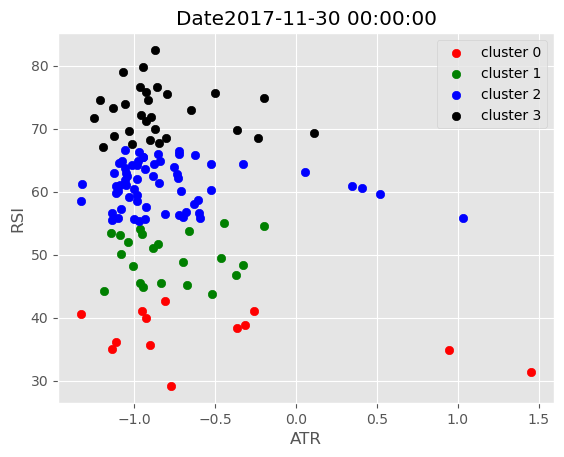

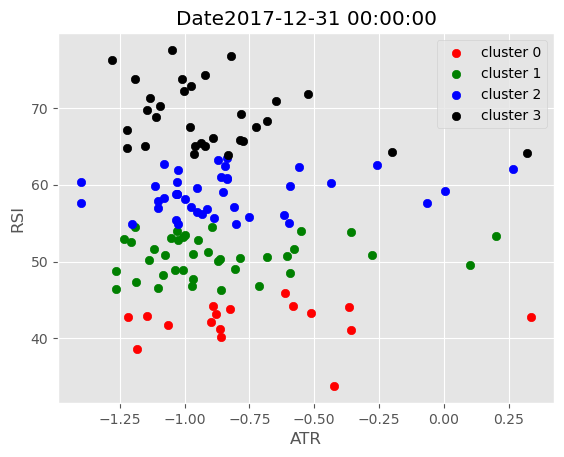

In [ ]:
# plot the graph
plt.style.use('ggplot')

for i in data1.index.get_level_values('Date').unique().tolist():
    g=data1.xs(i ,level=0)
    plt.title(f'Date{i}')
    plt.grid(True)
    plt.xlabel('ATR')
    plt.ylabel('RSI')
    plot_clusters(g)


In [77]:
#Now we want the highest upward momentum ao will focus to rsi around cluster 65 to 75
#Random intizalizrion wont work in this case, so will give the intial center and want to arouund to rsi
# we will cluster around 70 ,55, 40, 25  for rsi
#sow we will bw editing kmeans

In [78]:
target_value=[25,40,55,70]
intial_cent=np.zeros((len(target_value),18))
intial_cent[:,6]=target_value
intial_cent

array([[ 0.,  0.,  0.,  0.,  0.,  0., 25.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 40.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [100]:
# We are getting the consistant cluster around the graph which help us select the stock for portfolio
# And since Cluster 3 have the good momentum  through previous month we select the stock for given month

# 7) Selcting the stock based on our clustering for each month and form a portfolio based on Max sharpe ratio optimization
    .We will filter  out the stock correspondingo the cluster we choose based on hypothesis
    .Momentum is persistant and we will choose the stock Clustered around RSI 70 thus we select stock of cluster 3

In [101]:
filter_stock=data1[data1.cluster==3].copy()

In [102]:
filter_stock

Garman_klass_Voltaility      MACD       atr   bb_high  \
Date       Indices                                                          
2017-11-30 AMZN                    0.000100  0.597079 -1.015894  4.107833   
           AXP                    -0.002249  0.167640 -1.030977  4.502716   
           AZO                     0.000346  0.667841 -0.798482  6.523828   
           BA                      0.000185  0.423159 -0.930763  5.560970   
           BAC                    -0.008187  0.333494 -0.850309  3.246819   
...                                     ...       ...       ...       ...   
2023-10-31 TMUS                    0.000110  0.183948  0.771569  4.982609   
           UNH                     0.000044  1.190474  0.505017  6.297352   
           VRTX                    0.000273  0.261856  0.501861  5.931307   
           VZ                      0.000064  1.277328 -0.125110  3.585953   
           WMT                     0.000050  0.108936  0.247323  5.110178   

                      bb_low    bb_mid        rsi  return_1M  return_2M  \
Date       Indices                                                        
2017-11-30 AMZN     4.015297  4.061565  67.625746   0.064662   0.106372   
           AXP      4.449011  4.475864  69.591274   0.022927   0.041305   
           AZO      6.352353  6.438090  75.556244   0.164987   0.074246   
           BA       5.506889  5.533930  71.151674   0.078719   0.046287   
           BAC      3.157659  3.202239  67.654654   0.032860   0.056607   
...                      ...       ...        ...        ...        ...   
2023-10-31 TMUS     4.922913  4.952761  56.926821   0.027205   0.027547   
           UNH      6.243732  6.270542  61.952116   0.062219   0.062135   
           VRTX     5.864551  5.897929  52.930312   0.041324   0.019574   
           VZ       3.414686  3.500320  62.704197   0.107061   0.012781   
           WMT      5.056815  5.083496  56.268946   0.021760   0.002457   

                    return_3M  return_6M  return_9M  return_12M    Mkt-RF  \
Date       Indices                                                          
2017-11-30 AMZN      0.062668   0.028422   0.037477    0.038184  1.315689   
           AXP       0.044407   0.041956   0.023715    0.027090  1.242082   
           AZO       0.091281   0.021092  -0.007747   -0.010888  0.506338   
           BA        0.051073   0.068962   0.051037    0.054468  1.006630   
           BAC       0.057968   0.040482   0.016574    0.025633  1.338284   
...                       ...        ...        ...         ...       ...   
2023-10-31 TMUS      0.014523  -0.000046  -0.004123   -0.004336  0.339265   
           UNH       0.020178   0.015559   0.009137   -0.001774  0.789396   
           VRTX      0.009159   0.010195   0.012746    0.012489  0.529646   
           VZ        0.017303  -0.010160  -0.012482    0.000756  0.510073   
           WMT       0.008540   0.014525   0.015540    0.012858  0.614980   

                         SMB       HML       RMW       CMA  cluster  
Date       Indices                                                   
2017-11-30 AMZN    -0.592625 -0.487052 -0.557366 -0.082638        3  
           AXP     -0.376020  0.712815 -0.827422 -0.328363        3  
           AZO      0.375992 -0.280234  1.303794  0.177999        3  
           BA       1.300058  0.213564  0.234437  0.126450        3  
           BAC     -0.287248  1.336022 -0.717303 -0.679205        3  
...                      ...       ...       ...       ...      ...  
2023-10-31 TMUS     0.887151 -0.324479  0.606457 -0.040780        3  
           UNH     -0.001996 -0.293804 -0.196102  0.653827        3  
           VRTX     0.075380 -0.966041  0.099221  0.858034        3  
           VZ      -0.361032  0.034625  0.304505  0.577452        3  
           WMT     -0.461589 -0.304508  0.376127  0.737501        3  

[2018 rows x 19 columns]

In [103]:
# Idea is to create a dictionary with first day of next month and the stock for next month

In [104]:
filter_stock=filter_stock.reset_index(level=1)

In [105]:
filter_stock

,Indices,Garman_klass_Voltaility,MACD,atr,bb_high,bb_low,bb_mid,rsi,return_1M,return_2M,return_3M,return_6M,return_9M,return_12M,Mkt-RF,SMB,HML,RMW,CMA,cluster
Date,,,,,,,,,,,,,,,,,,,,
2017-11-30,AMZN,0.000100,0.597079,-1.015894,4.107833,4.015297,4.061565,67.625746,0.064662,0.106372,0.062668,0.028422,0.037477,0.038184,1.315689,-0.592625,-0.487052,-0.557366,-0.082638,3
2017-11-30,AXP,-0.002249,0.167640,-1.030977,4.502716,4.449011,4.475864,69.591274,0.022927,0.041305,0.044407,0.041956,0.023715,0.027090,1.242082,-0.376020,0.712815,-0.827422,-0.328363,3
2017-11-30,AZO,0.000346,0.667841,-0.798482,6.523828,6.352353,6.438090,75.556244,0.164987,0.074246,0.091281,0.021092,-0.007747,-0.010888,0.506338,0.375992,-0.280234,1.303794,0.177999,3
2017-11-30,BA,0.000185,0.423159,-0.930763,5.560970,5.506889,5.533930,71.151674,0.078719,0.046287,0.051073,0.068962,0.051037,0.054468,1.006630,1.300058,0.213564,0.234437,0.126450,3
2017-11-30,BAC,-0.008187,0.333494,-0.850309,3.246819,3.157659,3.202239,67.654654,0.032860,0.056607,0.057968,0.040482,0.016574,0.025633,1.338284,-0.287248,1.336022,-0.717303,-0.679205,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,TMUS,0.000110,0.183948,0.771569,4.982609,4.922913,4.952761,56.926821,0.027205,0.027547,0.014523,-0.000046,-0.004123,-0.004336,0.339265,0.887151,-0.324479,0.606457,-0.040780,3
2023-10-31,UNH,0.000044,1.190474,0.505017,6.297352,6.243732,6.270542,61.952116,0.062219,0.062135,0.020178,0.015559,0.009137,-0.001774,0.789396,-0.001996,-0.293804,-0.196102,0.653827,3
2023-10-31,VRTX,0.000273,0.261856,0.501861,5.931307,5.864551,5.897929,52.930312,0.041324,0.019574,0.009159,0.010195,0.012746,0.012489,0.529646,0.075380,-0.966041,0.099221,0.858034,3


In [106]:
# Now we will move the date to beginning of the first month as all the stock are at end of last month
filter_stock.index=filter_stock.index+pd.DateOffset(1)

In [107]:
filter_stock=filter_stock.reset_index().set_index(['Date','Indices'])

In [108]:
dates=filter_stock.index.get_level_values('Date').unique().tolist()

In [109]:
dates

[Timestamp('2017-12-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-02-01 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-01 00:00:00'),
 Timestamp('2018-05-01 00:00:00'),
 Timestamp('2018-06-01 00:00:00'),
 Timestamp('2018-07-01 00:00:00'),
 Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-

In [110]:
fixed_dates={}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')]=filter_stock.xs(d, level=0).index.tolist()

## Now we wil define  portfolio Optimization Function
    . we will define a function which optimizes weights  using Pyportfolio package and efficientfrontier optimizer to maximize the sharpe ratio 
    . to  optimization  the weights of a given portfolio  we would need to supply 1 year prices to the funtction
    . Apply single stock weights bounds  constraint for diversification( minimum half of equal weights and maximun 10% of portfolio)

In [111]:
pip install pyportfolioopt

Note: you may need to restart the kernel to use updated packages.


In [112]:

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [242]:
# Now we have to assign weights to the stock and so we have to find those weights 
def optimize_price(price,lower_bound=0):
    returns=expected_returns.mean_historical_return(prices=price,
                                                    frequency=252)
    cov=risk_models.sample_cov(prices=price,
                               frequency=252)
    ef=EfficientFrontier(expected_returns=returns,
                         cov_matrix=cov,
                         weight_bounds=(lower_bound,0.1),
                         solver='SCS')
    weights=ef.max_sharpe(risk_free_rate=0.02)
    
    
    return ef.clean_weights()


# this funtion we have to supply the one year stock prices
# In the function there is weight_bounds which is the constraint between  0-1 ,which may give us some stock
# with zero weight and some 100 weight.  
# For upper bound we choose 10% weightage and for lower bound we create dyamic metrics ,because for lower
# bound when we optimzation we half the weight of equally weighted portfolio (eg 20 stock weightage is 5%,
# then 2.5% is half and thus we may assign that in lower bound).
# This is to ensure we have diversified portfolio 


In [247]:
# Now we are gonna download the fresh stock prices based on fixed_dates 
# we will create first portfolio for our 1 month in 2017-12 based on fixed_dates and optimize through 
# optimize_price whixh require one year of the data

## Downloading the fresh stock

In [117]:
stock=data.index.get_level_values('Indices').unique().tolist()


In [119]:
new_df=yf.download(tickers=stock,
                   start=data.index.get_level_values('Date').unique()[0]-pd.DateOffset(months=12),
                   end=data.index.get_level_values('Date').unique()[-1])

[*********************100%%**********************]  176 of 176 completed


In [120]:
new_df

Adj Close                                                 \
                  AAL        AAPL        ABBV        ABNB        ABT   
Date                                                                   
2016-11-30  44.876514   25.747690   44.699745         NaN  33.597481   
2016-12-01  44.209743   25.507734   43.494022         NaN  33.182686   
2016-12-02  44.547958   25.603251   43.692532         NaN  33.447445   
2016-12-05  44.180763   25.419216   44.743858         NaN  33.915184   
2016-12-06  44.866844   25.614899   45.302608         NaN  33.906361   
...               ...         ...         ...         ...        ...   
2023-10-24  11.210000  173.440002  146.309998  122.010002  94.809998   
2023-10-25  11.040000  171.100006  145.259995  118.500000  93.570000   
2023-10-26  11.150000  166.889999  145.199997  115.470001  93.980003   
2023-10-27  10.920000  168.220001  138.929993  114.089996  92.849998   
2023-10-30  11.180000  170.289993  141.889999  116.949997  93.000000   

                                                                        ...  \
                   ACN        ADBE         ADI         ADP        ADSK  ...   
Date                                                                    ...   
2016-11-30  107.214012  102.809998   65.050964   82.871902   72.610001  ...   
2016-12-01  105.625076   99.510002   60.468319   82.656158   69.220001  ...   
2016-12-02  105.292923   99.730003   61.432156   82.198738   70.570000  ...   
2016-12-05  105.678925  101.949997   61.861519   82.897797   71.180000  ...   
2016-12-06  106.298355  101.550003   62.212006   82.854630   76.320000  ...   
...                ...         ...         ...         ...         ...  ...   
2023-10-24  296.089996  539.559998  164.929993  240.449997  205.039993  ...   
2023-10-25  292.679993  521.140015  159.789993  218.330002  200.210007  ...   
2023-10-26  292.040009  514.280029  160.860001  218.839996  196.119995  ...   
2023-10-27  290.040009  508.119995  160.570007  214.839996  195.149994  ...   
2023-10-30  292.700012  526.940002  155.880005  216.080002  197.789993  ...   

              Volume                                                  \
                 VLO     VRTX     VTRS        VZ       WBA       WDC   
Date                                                                   
2016-11-30  14238400  2292700  5522900  20698900   5951900   5383000   
2016-12-01  10720500  2662600  5125300  12982800   4463500   5508400   
2016-12-02   5295700  4580500  3543400  10650700   3928600   3496900   
2016-12-05   8277900  2588600  3528300  13074700   2800200   6865600   
2016-12-06   5149300  1816700  5788900  13581500   2911400   5049500   
...              ...      ...      ...       ...       ...       ...   
2023-10-24   2913400   997300  8489700  61617900  10157700   4314300   
2023-10-25   3056200   958000  6589300  30832800  10408400   2764400   
2023-10-26   3992500   942100  7572300  34367000   8832500  17872200   
2023-10-27   3674500   910700  6167700  23924800   9208600   6533300   
2023-10-30   2925400   872400  7585800  31497700   9239900  16960100   

                                                   
                 WFC       WMT     WYNN       XOM  
Date                                               
2016-11-30  26567200   9326100  2618300  22696200  
2016-12-01  35623100   6849800  3881900  13005600  
2016-12-02  21894700   6674200  1955500   9706600  
2016-12-05  24793900  10527900  1678600  11741100  
2016-12-06  30706700   7778000  2892100  11293600  
...              ...       ...      ...       ...  
2023-10-24  15097800   5845000  1335000  16786100  
2023-10-25  13849000   5540600  1518500  22047300  
2023-10-26  15480300   5406700  2183400  18768300  
2023-10-27  13582800   4609900  1587500  23092000  
2023-10-30  14141900   4217900  1343100  19379900  

[1740 rows x 1056 columns]

## Statergy
    . Calculate daily return of the stock that may end up in our portfolio 
    . Then loop over each month start ,select the stock of each month and calculate their weight for next month
    . if Maximum Shrape ratio optimaation fails for that month then provide equal weights
    . Calculate each day portfolio return

In [121]:
return_dataframe=np.log(new_df['Adj Close']).diff() 
return_dataframe

,AAL,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,ADSK,...,VLO,VRTX,VTRS,VZ,WBA,WDC,WFC,WMT,WYNN,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01,-0.014969,-0.009363,-0.027344,NaN,-0.012423,-0.014931,-0.032624,-0.073051,-0.002607,-0.047813,...,-0.016874,-0.047553,-0.015970,-0.000601,-0.006038,-0.032732,0.026479,0.003402,-0.027032,-0.000688
2016-12-02,0.007621,0.003738,0.004554,NaN,0.007947,-0.003150,0.002208,0.015814,-0.005549,0.019315,...,0.015247,-0.030266,-0.001111,-0.001204,0.010512,0.027851,-0.014085,0.002967,-0.006366,-0.002295
2016-12-05,-0.008277,-0.007214,0.023777,NaN,0.013887,0.003659,0.022016,0.006965,0.008469,0.008607,...,0.048589,0.000662,-0.009492,-0.001205,-0.001293,-0.020090,0.014269,-0.013350,-0.002741,0.005043
2016-12-06,0.015410,0.007669,0.012410,NaN,-0.000260,0.005844,-0.003931,0.005650,-0.000521,0.069723,...,0.003095,0.033451,0.005873,0.012187,-0.003418,0.027952,0.021839,0.005987,0.038000,0.000914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,-0.007111,0.002540,0.010858,0.013367,-0.010179,0.003891,-0.001574,0.006448,-0.002948,0.026289,...,-0.014873,0.004667,0.021077,0.088656,-0.027234,0.027134,-0.005079,0.013816,0.017434,-0.009732
2023-10-25,-0.015281,-0.013584,-0.007202,-0.029190,-0.013165,-0.011584,-0.034735,-0.031661,-0.096504,-0.023838,...,-0.015177,-0.017313,-0.015487,-0.017944,0.013941,-0.018323,-0.006385,-0.003006,-0.027502,0.001843
2023-10-26,0.009914,-0.024913,-0.000413,-0.025902,0.004372,-0.002189,-0.013251,0.006674,0.002333,-0.020640,...,-0.011895,-0.004860,0.002227,0.022888,0.001383,-0.097541,0.015760,-0.006101,-0.015866,-0.009159


In [260]:
# we have start date,end date and stock for given month now we calculate the weights using optimization
# for that we need 1 year prior data which we can from the new stock data we downloaded
# so we want to calculate the weight of all the stock weight at the start of each month
# in this case first month is december so for that we have to provide 1 year data to calculate date

In [271]:
# At the start of the month we want to select the return of the month and know the return for the next month
portfolio_df=pd.DataFrame()
for start_date in fixed_dates.keys():
    try:
        end_date=(pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        #end of the month ,as we are investing for a month and rebalancing  
        cols=fixed_dates[start_date] #this is gonna be our columns i.e srock for each month from which we will create portfolio
        optimzation_start_date=(pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d') 
        optimzation_end_date=(pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d') 
        round(1/(len(optimzation_df.columns)*2),2)
        # this gives of the equally distributed weights of the all the stock for a single month which is used in lower bound
        optimzation_df=new_df[optimzation_start_date:optimzation_end_date]['Adj Close'][cols]
        success=False
        try:
            weights=optimize_price(price=optimzation_df,
                                   lower_bound=round(1/(len(optimzation_df.columns)*2),3))
            weights=pd.DataFrame(weights,index=pd.Series(0)) 
            success=True
        except:
            print(f'Max Sharpie optimization Failed for {start_date},Date,Continuing with equal weights')
        if success==False:
            weights=pd.DataFrame([1/len(optimzation_df.columns)  for i in range(len(optimzation_df.columns))],
             index=optimzation_df.columns.tolist(),
             columns=pd.Series(0)).T
        #we can  use this with the return_dataframe to multiply the weights of each stock for the given month by the return for that stock for everyday
        # Also to calculate the portfolio return for each day
        temp_df=return_dataframe[start_date:end_date]#The stock and their return
        temp_df=temp_df.stack().to_frame('return').reset_index(level=0)\
           .merge(weights.stack().to_frame('weights').reset_index(level=0,drop=True),
                 left_index=True,
                 right_index=True,)\
           .reset_index().set_index(['Date','index']).unstack().stack() 
        # this has merged the return and the weights  of the stock for each day of the month
        # now we are gonna multiply their their weights and return and get weighted return for every day of given month
        temp_df.index.names=['Date','index']
        temp_df['weighted_return']=temp_df['return'] * temp_df['weights']# get weighted return of each stock of each day of a month
        # Now we have to calculate the sum of the daily weighted return which we our prtfolio return for the given day
        temp_df=temp_df.groupby(level=0)['weighted_return'].sum().to_frame('stratergy_return')
        portfolio_df=pd.concat([portfolio_df,temp_df],axis=0)
    except Exception as e:
        print(e)
portfolio_df = portfolio_df.drop_duplicates()        
portfolio_df

Max Sharpie optimization Failed for 2018-04-01,Date,Continuing with equal weights
Max Sharpie optimization Failed for 2018-05-01,Date,Continuing with equal weights
Max Sharpie optimization Failed for 2020-03-01,Date,Continuing with equal weights
Max Sharpie optimization Failed for 2021-02-01,Date,Continuing with equal weights
Max Sharpie optimization Failed for 2022-10-01,Date,Continuing with equal weights
'return'


,stratergy_return
Date,
2017-12-01,-0.007031
2017-12-04,0.001250
2017-12-05,-0.003742
2017-12-06,-0.000562
2017-12-07,0.005869
...,...
2023-10-24,0.016384
2023-10-25,-0.022061
2023-10-26,-0.018401


# Visualizing  the return of our portfolio

<Axes: xlabel='Date'>

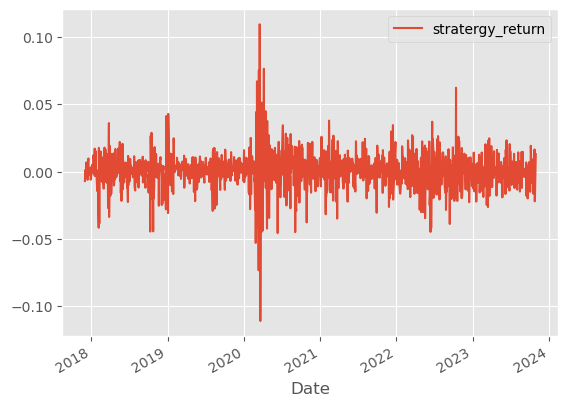

In [273]:
portfolio_df.plot()

In [275]:
spy =yf.download(tickers='SPY',start='2016-01-01',end=dt.date.today()
                )

[*********************100%%**********************]  1 of 1 completed


In [280]:
spy_net=np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'},axis=1)

In [282]:
portfolio_df=portfolio_df.merge(spy_net,
                                left_index=True,
                                right_index=True)

In [283]:
 portfolio_df

,stratergy_return,SPY Buy&Hold
Date,,
2017-12-01,-0.007031,-0.002078
2017-12-04,0.001250,-0.001211
2017-12-05,-0.003742,-0.003603
2017-12-06,-0.000562,0.000190
2017-12-07,0.005869,0.003148
...,...,...
2023-10-24,0.016384,0.007511
2023-10-25,-0.022061,-0.014456
2023-10-26,-0.018401,-0.012047


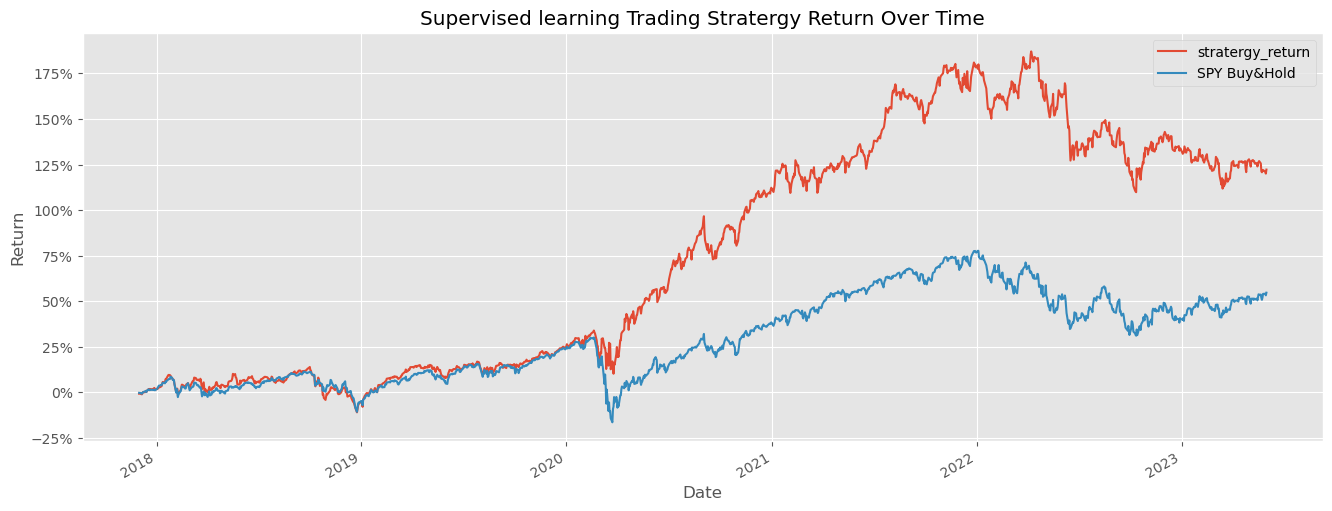

In [294]:
# now to calculate the cumlative return for both the columns and plot them and compare them
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return= np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-06-01'].plot(figsize=(16,6))
plt.title('Supervised learning Trading Stratergy Return Over Time')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()